# Object Detection from scratch

The traditional way to approach Object Detection is to have an architecture composed of 2 parts :
Feature extractor (=Backbone) + Object Detector Head

In a normal setting, you would pick a pre-trained network (Resnet, Mobilenet, ...) ,and train (or finetune) the "head" part. In order to make it more challenging for us, we will train the whole model from scratch. 

For the object detector head, we distinguish 2 families of architectures :

- **One-Stage Detectors** (e.g., You Only Look Once (YOLO), SSD)
    + *Advantage:* Fast inference time (FPS), Simpler architecture
    - *Drawback:* Accuracy(on small objects)
- **Two Stage Detectors** (e.g., R-CNN, Mask R-CNN)
    + *Advantage:* Accuracy
    - *Drawback:* Complex architecture, Slow inference time (FPS), Long training time

Among these 2 families, we can further distinguish between **Anchor-based** and **Anchor-free detectors**. Current SOTA results are all achieved using the Anchor-based approach (RetinaNet for one stage detectors and Mask R-CNN for two stage detectors). However, anchor based methods are complex by nature and do not generalize well to objects that differ in size from the training set.  

For this project, we will use **Keras** to implement a **anchor free one-stage detector**.

In [1]:
# FIX FOR GPU issue
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [40]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from utils_maskdataset import (
    display_multipleplots,
    extract_boxes,
    get_filenames_fromdir,
)


## CNN Architecture

The **feature extractor** in our model is composed of blocks of **depthwise separable convolutions** and **batch norm layers**. We use Depthwise separable convolutions instead of normal 2D convolutions because they lead to smaller models, have faster convergence rates and are less prone to overfitting. Batch norm is used to create deeper networks and to speed up training. We downsample our feature maps by adding strides (strides=2) instead of using Max pooling layers. This is done to keep the spatial information of the feature map. A model of our feature extractor : &nbsp;

![Feature Extractor](./Images_notebook/Feature_extractor.jpg) &nbsp;

The building block of our feature extractor:

In [3]:
def SeparableConv_BN_Block(input_x, num_filters):
    x = K.layers.SeparableConv2D(
        num_filters, 3, strides=2, padding="same", use_bias=False
    )(input_x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation("relu")(x)

    x = K.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)

    return K.layers.Activation("relu")(x)


The **detector head** is inspired from the **FCOS** paper by Tian et al., 2019 [[arXiv](https://arxiv.org/abs/1904.01355)].
View of the FCOS architecture :

![Detector Head](./Images_notebook/Detector_head.png) &nbsp;

The main difference between our architecture and the FCOS architecture is that FCOS uses multiple detector heads and a Feature Pyramid Network to feed these detectors.
Our object detector head contains 3 branches (centerness, regression, classification) :  
- Classification : 2 binary masks to classify objects between mask and no mask
- Centerness : centerness of predicted objects 
- Regression : bounding box dimensions

The centerness is used to "downweight the scores of bounding boxes far from the center" by multiplying the classification with the centerness. 

The upsampling layers :

In [4]:
def SeparableConv_BN_Layer(
    input_x, num_filters, depthwise_regularizer=None, pointwise_regularizer=None
):
    x = K.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(
        input_x
    )
    x = K.layers.BatchNormalization()(x)
    return K.layers.Activation("relu")(x)


We need to define some parameters before building our model:

In [5]:
WIDTH = 800
HEIGHT = 608
IMAGE_SIZE = (HEIGHT, WIDTH)  # Input of our CNN
STRIDE = 8  # Factor by which we divide the input image (Output of our CNN = IMAGE_SIZE / stride)
class_names = ["mask", "nomask"]
NUM_CLASS = len(class_names)


In [6]:
def get_model(img_size, num_class):
    inputs = K.Input(shape=img_size + (3,))
    x = K.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

    conv1 = K.layers.Conv2D(32, 5, activation="relu", padding="same", use_bias=False)(x)

    # Feature extractor backbone
    block1 = SeparableConv_BN_Block(conv1, 64)
    block2 = SeparableConv_BN_Block(block1, 128)
    block3 = SeparableConv_BN_Block(block2, 256)

    # Classification Head
    clas1 = SeparableConv_BN_Layer(block3, 128)
    clas2 = SeparableConv_BN_Layer(clas1, 128)
    clas3 = SeparableConv_BN_Layer(clas2, 128)
    # 2 binary classes -> sigmoid
    output_classification = K.layers.SeparableConv2D(
        num_class, 3, padding="same", activation="sigmoid", name="Classification"
    )(clas3)

    # Centerness Head
    cent1 = SeparableConv_BN_Layer(
        block3, 128, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    cent2 = SeparableConv_BN_Layer(
        cent1, 128, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    cent3 = SeparableConv_BN_Layer(
        cent2, 128, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    output_centerness = K.layers.SeparableConv2D(
        1, 3, padding="same", activation="sigmoid", name="Centerness"
    )(cent3)

    # Regression Head
    reg1 = SeparableConv_BN_Layer(
        block3, 256, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    reg2 = SeparableConv_BN_Layer(
        reg1, 256, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    reg3 = SeparableConv_BN_Layer(
        reg2, 256, depthwise_regularizer="l2", pointwise_regularizer="l2"
    )
    output_regression = K.layers.SeparableConv2D(
        4, 3, padding="same", name="Regression", activation="relu"
    )(reg3)

    model = K.Model(
        inputs, [output_centerness, output_classification, output_regression]
    )
    return model


In [7]:
model = get_model(img_size=IMAGE_SIZE, num_class=NUM_CLASS)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 800, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 608, 800, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 800, 32) 2400        rescaling[0][0]                  
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 304, 400, 64) 2336        conv2d[0][0]                     
_______________________________________________________________________________________

The **loss function** is defined in the FCOS paper by : 

![Loss function](./Images_notebook/LossFunction.png) &nbsp;

with : Lcls being the focal loss (for the classification) and Lreg being the IOU loss (for the regression)

We need to add the binary cross entropy loss (for the centerness) to the formula above to get the complete loss function. 

The IOU loss is given in the UnitBox paper by (Yu et al., 2016) [[arXiv](https://arxiv.org/abs/1608.01471)].
![Loss function](./Images_notebook/IOULoss.png) &nbsp;

The binary cross entropy loss function is already defined in Keras, so we will only define the focal loss and the IOU Loss. The two functions were taken from 2 separate Github repositeries. ([IOULoss from UnitBox Implementation](https://github.com/zhimingluo/UnitBox_TF) and [Focal Loss](https://github.com/mkocabas/focal-loss-keras))

In [26]:
def IOULoss(y_true, y_pred):
    _EPSILON = 10e-8
    # the estimate position
    xt, xb, xl, xr = tf.split(y_pred, num_or_size_splits=4, axis=3)

    # the ground truth position
    gt, gb, gl, gr = tf.split(y_true, num_or_size_splits=4, axis=3)

    # compute the bounding box size
    X = (xt + xb) * (xl + xr)
    G = (gt + gb) * (gl + gr)

    # compute the IOU
    Ih = tf.minimum(xt, gt) + tf.minimum(xb, gb)
    Iw = tf.minimum(xl, gl) + tf.minimum(xr, gr)

    I = tf.multiply(Ih, Iw, name="intersection")
    U = X + G - I + _EPSILON

    IoU = tf.divide(I, U, name="IoU")

    L = tf.where(
        tf.less_equal(gt, tf.constant(0.01, dtype=tf.float32)),
        tf.zeros_like(xt, tf.float32),
        -tf.math.log(IoU + _EPSILON),
    )

    return tf.reduce_mean(L)

In [27]:
def focal_loss(y_true, y_pred):
    gamma = 2
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.backend.mean(
        alpha
        * K.backend.pow(1.0 - pt_1, gamma)
        * K.backend.log(pt_1 + K.backend.epsilon())
    ) - K.backend.mean(
        (1 - alpha)
        * K.backend.pow(pt_0, gamma)
        * K.backend.log(1.0 - pt_0 + K.backend.epsilon())
    )


## Data Loading & preprocessing

We need to transform the raw data into a vectorized & standardized representations. We start by preparing the preprocessing function needed for the target data. We will then load the data as numpy arrays as the dataset is small enough to fit in memory.

In [8]:
dataset_path = Path("data")

Load the data filenames in python dicts.

In [9]:
train_filename_images = dict()
train_filename_labels = dict()
train_filename_images, train_filename_labels = get_filenames_fromdir(
    dataset_path, "train"
)

valid_filename_images = dict()
valid_filename_labels = dict()
valid_filename_images, valid_filename_labels = get_filenames_fromdir(
    dataset_path, "valid"
)

test_filename_images = dict()
test_filename_labels = dict()
test_filename_images, test_filename_labels = get_filenames_fromdir(dataset_path, "test")


train  :  105 images
valid  :  29 images
test  :  15 images


This model outputs 3 matrices for the 3 head branches. In order to apply backpropagation, we need to transform the labels from the XML files in the format expected by our model.

In [10]:
def preprocess_classification_target(
    path, stride=STRIDE, image_size_CNN=IMAGE_SIZE, num_class=NUM_CLASS
):
    # Feature map (=output of the CNN) = Input of the CNN divided by the stride
    height_input, width_input = image_size_CNN
    width_target = int(width_input / stride)
    height_target = int(height_input / stride)
    featuremap_size = (height_target, width_target)

    # extract details from a single annotation file
    boxes_mask, boxes_nomask, width_original, height_original = extract_boxes(path)
    classification_target = np.zeros(
        ((height_original, width_original, num_class))
    )  # uint8
    for Xmin, Ymin, Xmax, Ymax in boxes_mask:
        classification_target[Ymin:Ymax, Xmin:Xmax, 0] = 1
    for Xmin, Ymin, Xmax, Ymax in boxes_nomask:
        classification_target[Ymin:Ymax, Xmin:Xmax, 1] = 1

    # Resize to the feature map size
    classification_target_resized = resize(
        classification_target, (featuremap_size)
    )  # float
    classification_target_resized = np.around(
        classification_target_resized
    )  # rounding (necessary for small labels)
    return classification_target_resized.astype("uint8")


In [12]:
def preprocess_regression_target(
    path, stride=STRIDE, image_size_CNN=IMAGE_SIZE, num_class=NUM_CLASS
):
    # Feature map (=output of the CNN) = Input of the CNN divided by the stride
    height_input, width_input = image_size_CNN
    width_target = int(width_input / stride)
    height_target = int(height_input / stride)
    featuremap_size = (height_target, width_target)

    # extract details from a single annotation file
    boxes_mask, boxes_nomask, width_original, height_original = extract_boxes(path)

    # List of bounding box sizes
    boundingbox_size = []
    for Xmin, Ymin, Xmax, Ymax in boxes_mask:
        size = (Xmax - Xmin) * (Ymax - Ymin)
        boundingbox_size += [(size, (Xmin, Ymin, Xmax, Ymax))]
    for Xmin, Ymin, Xmax, Ymax in boxes_nomask:
        size = (Xmax - Xmin) * (Ymax - Ymin)
        boundingbox_size += [(size, (Xmin, Ymin, Xmax, Ymax))]
    # Sorted list from biggest bounding box to smallest
    boundingbox_size.sort(reverse=True)

    # Regression target (l, t, r, b) : distances from the 4 sides of the bbox
    regression_target = np.zeros(((height_target, width_target, 4)))
    for bbox in boundingbox_size:
        __, bbox_coords = bbox

        # Bounding box in original coordinates
        Xmin, Ymin, Xmax, Ymax = bbox_coords

        # Convert Bounding box to target bounding box
        ratio_w = width_target / width_original
        ratio_h = height_target / height_original

        Xmin = int(ratio_w * Xmin)
        Ymin = int(ratio_h * Ymin)
        Xmax = int(ratio_w * Xmax)
        Ymax = int(ratio_h * Ymax)

        bbox_area = np.zeros((Ymax - Ymin, Xmax - Xmin))

        # Calculating the distance from each edge
        left = np.arange(Xmax - Xmin)  # dim (Xmax-Xmin,)
        top = np.arange(Ymax - Ymin).reshape(Ymax - Ymin, 1)  # dim (Ymax-Ymin, 1)
        left_target = bbox_area + left  # dim (Xmax-Xmin, Ymax-Ymin)
        right_target = np.flip(left_target)  # dim (Xmax-Xmin, Ymax-Ymin)
        top_target = bbox_area + top
        bottom_target = np.flip(top_target)

        # Normalized by target shape
        regression_target[Ymin:Ymax, Xmin:Xmax, 0] = left_target / width_target
        regression_target[Ymin:Ymax, Xmin:Xmax, 1] = top_target / height_target
        regression_target[Ymin:Ymax, Xmin:Xmax, 2] = right_target / width_target
        regression_target[Ymin:Ymax, Xmin:Xmax, 3] = bottom_target / height_target

    return regression_target


In [13]:
def preprocess_centerness_target(regression_original):
    # Formula for centerness given in the FCOS paper
    min_l_r = np.minimum(regression_original[..., 0], regression_original[..., 2])
    min_t_b = np.minimum(regression_original[..., 1], regression_original[..., 3])
    max_l_r = np.maximum(regression_original[..., 0], regression_original[..., 2])
    max_t_b = np.maximum(regression_original[..., 1], regression_original[..., 3])
    numerator = min_l_r * min_t_b
    denominator = max_l_r * max_t_b
    # Avoids any problems with div by 0
    result = np.divide(
        numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0
    )
    centerness_target = np.sqrt(result)

    # Adds a dimension
    centerness_target = np.expand_dims(centerness_target, axis=-1)

    return centerness_target


Functions to load single files (image or annotation) as numpy arrays:

In [14]:
def path_to_input_image(path, image_size):
    return img_to_array(load_img(path, target_size=image_size))


In [15]:
def path_to_target(path, stride=STRIDE, image_size_CNN=IMAGE_SIZE, num_class=NUM_CLASS):
    clas_target = preprocess_classification_target(
        path, stride=stride, image_size_CNN=image_size_CNN, num_class=num_class
    )
    reg_target = preprocess_regression_target(
        path, stride=stride, image_size_CNN=image_size_CNN, num_class=num_class
    )
    center_target = preprocess_centerness_target(reg_target)

    return center_target, clas_target, reg_target


Let's check visually the labels we created:

In [22]:
center_vis, clas_vis, reg_vis = path_to_target(
    dataset_path / "train" / train_filename_labels[30]
)


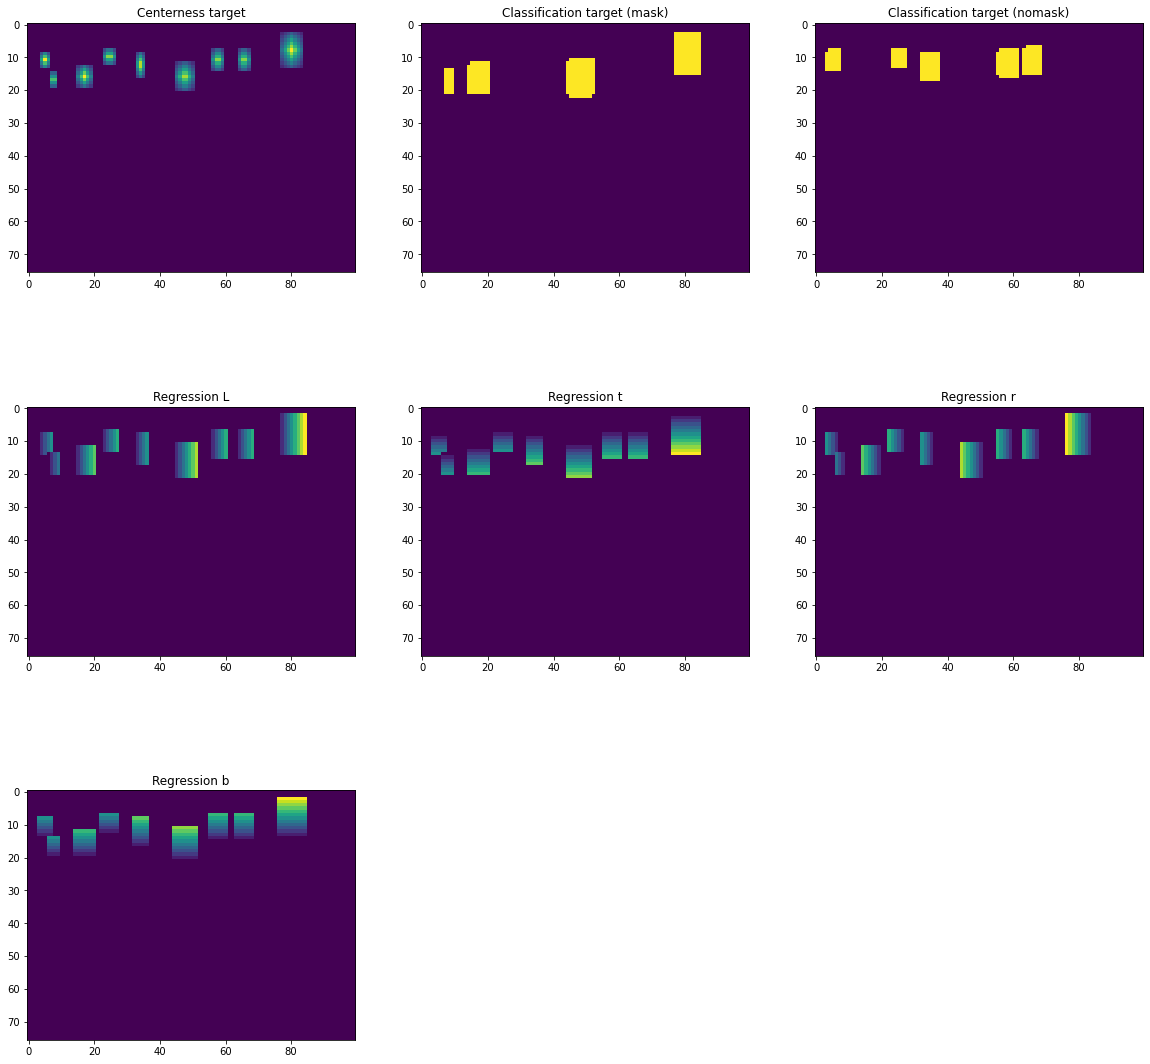

In [23]:
# Plotting target data (for 1 example)
images_to_plot = [
    center_vis[..., 0],
    clas_vis[..., 0],
    clas_vis[..., 1],
    reg_vis[..., 0],
    reg_vis[..., 1],
    reg_vis[..., 2],
    reg_vis[..., 3],
]
images_title = [
    "Centerness target",
    "Classification target (mask)",
    "Classification target (nomask)",
    "Regression L",
    "Regression t",
    "Regression r",
    "Regression b",
]
display_multipleplots(images_to_plot, images_title, columns=3, rows=3, figsize=(20, 20))


The labels are consistent with what we expected, we can move on to load the whole dataset in numpy arrays.

In practice, you should apply some data augmentations to increase the size of the training dataset. However, we are not interested in maximizing the performance of our model, so we omit this step.

In [29]:
len_training = len(train_filename_images)

# Training data
x_train = np.zeros((len_training,) + IMAGE_SIZE + (3,), dtype="float32")
y_train_center = np.zeros(
    (len_training, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 1), dtype="float32"
)
y_train_classi = np.zeros(
    (len_training, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 2), dtype="float32"
)
y_train_regres = np.zeros(
    (len_training, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 4), dtype="float32"
)

for i in range(len_training):
    x_train[i] = path_to_input_image(
        dataset_path / "train" / train_filename_images[i + 1], IMAGE_SIZE
    )
    y_train_center[i], y_train_classi[i], y_train_regres[i] = path_to_target(
        dataset_path / "train" / train_filename_labels[i + 1], stride=STRIDE
    )


In [31]:
len_valid = len(valid_filename_images)

# Validation data
x_valid = np.zeros((len_valid,) + IMAGE_SIZE + (3,), dtype="float32")
y_valid_center = np.zeros(
    (len_valid, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 1), dtype="float32"
)
y_valid_classi = np.zeros(
    (len_valid, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 2), dtype="float32"
)
y_valid_regres = np.zeros(
    (len_valid, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 4), dtype="float32"
)

for i in range(len_valid):
    x_valid[i] = path_to_input_image(
        dataset_path / "valid" / valid_filename_images[i + 1], IMAGE_SIZE
    )
    y_valid_center[i], y_valid_classi[i], y_valid_regres[i] = path_to_target(
        dataset_path / "valid" / valid_filename_labels[i + 1], stride=STRIDE
    )


In [34]:
len_test = len(test_filename_images)

# Test data
x_test = np.zeros((len_test,) + IMAGE_SIZE + (3,), dtype="float32")
y_test_center = np.zeros(
    (len_test, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 1), dtype="float32"
)
y_test_classi = np.zeros(
    (len_test, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 2), dtype="float32"
)
y_test_regres = np.zeros(
    (len_test, int(HEIGHT / STRIDE), int(WIDTH / STRIDE), 4), dtype="float32"
)
for i in range(len_test):
    x_test[i] = path_to_input_image(
        dataset_path / "test" / test_filename_images[i + 1], IMAGE_SIZE
    )
    y_test_center[i], y_test_classi[i], y_test_regres[i] = path_to_target(
        dataset_path / "test" / test_filename_labels[i + 1], stride=STRIDE
    )


## Model Training

For the training, we use **Rmsprop** as optimizer. We run the model for 100 epochs with a batch size of **4** (the maximum for this laptop). 

We set up a couple of callbacks : 
- we reduce the learning rate if the validation loss doesn't improve for 10 epochs
- we stop the training, if the validation loss doesn't improve for 30 epochs

In [35]:
tf.keras.backend.clear_session()


In [37]:
model.compile(optimizer="Rmsprop", loss=["BinaryCrossentropy", focal_loss, IOULoss])

callbacks = [
    K.callbacks.EarlyStopping(patience=30),
    K.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=10, min_lr=0.00001
    ),
]


Launch the training:

In [38]:
EPOCH = 100
BATCH_SIZE = 4

history = model.fit(
    x_train,
    [y_train_center, y_train_classi, y_train_regres],
    epochs=EPOCH,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    validation_data=(x_valid, [y_valid_center, y_valid_classi, y_valid_regres]),
)


Epoch 1/100
27/27 [==============================] - 7s 259ms/step - loss: 0.7288 - Centerness_loss: 0.3686 - Classification_loss: 0.0536 - Regression_loss: 0.3066 - val_loss: 1.5412 - val_Centerness_loss: 0.6145 - val_Classification_loss: 0.1038 - val_Regression_loss: 0.8228
Epoch 2/100
27/27 [==============================] - 6s 204ms/step - loss: 0.4501 - Centerness_loss: 0.1915 - Classification_loss: 0.0246 - Regression_loss: 0.2340 - val_loss: 1.2410 - val_Centerness_loss: 0.5330 - val_Classification_loss: 0.0905 - val_Regression_loss: 0.6176
Epoch 3/100
27/27 [==============================] - 6s 204ms/step - loss: 0.4228 - Centerness_loss: 0.1768 - Classification_loss: 0.0232 - Regression_loss: 0.2228 - val_loss: 1.1880 - val_Centerness_loss: 0.4473 - val_Classification_loss: 0.0753 - val_Regression_loss: 0.6653
Epoch 4/100
27/27 [==============================] - 6s 206ms/step - loss: 0.4107 - Centerness_loss: 0.1689 - Classification_loss: 0.0223 - Regression_loss: 0.2195 - val

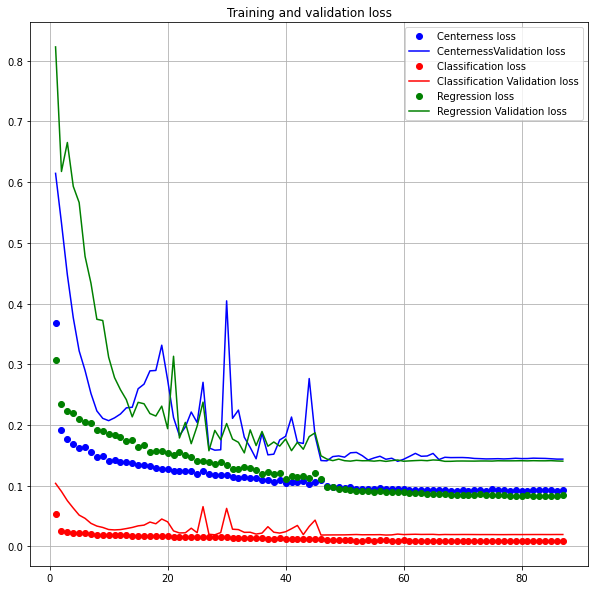

In [41]:
epochs = range(1, len(history.history["loss"]) + 1)
Centerness_loss = history.history["Centerness_loss"]
Classification_loss = history.history["Classification_loss"]
Regression_loss = history.history["Regression_loss"]

val_Centerness_loss = history.history["val_Centerness_loss"]
val_Classification_loss = history.history["val_Classification_loss"]
val_Regression_loss = history.history["val_Regression_loss"]
plt.figure(figsize=(10, 10))
plt.plot(epochs, Centerness_loss, "bo", label="Centerness loss")
plt.plot(epochs, val_Centerness_loss, "b", label="CenternessValidation loss")
plt.plot(epochs, Classification_loss, "ro", label="Classification loss")
plt.plot(epochs, val_Classification_loss, "r", label="Classification Validation loss")
plt.plot(epochs, Regression_loss, "go", label="Regression loss")
plt.plot(epochs, val_Regression_loss, "g", label="Regression Validation loss")
plt.title("Training and validation loss")
plt.grid()
plt.legend()


The training stops after the 87th epoch. By plotting the loss graph, we see the model converged.

### Debugging : Visualizing the CNN output channels

This section allows us to understand what each branch is learning and to detect potential problems.

In [42]:
def visualize_outputpredictions(folder, num_image):
    if folder == "train":
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_train[num_image], 0)
        )
        images_to_plot = [
            x_train[num_image].astype("uint8"),
            x_train[num_image].astype("uint8"),
            y_train_center[num_image, ..., 0],
            output_center[0, ..., 0],
            y_train_classi[num_image, ..., 0],
            output_classi[0, ..., 0],
            y_train_classi[num_image, ..., 1],
            output_classi[0, ..., 1],
            y_train_regres[num_image, ..., 0],
            output_regre[0, ..., 0],
            y_train_regres[num_image, ..., 1],
            output_regre[0, ..., 1],
            y_train_regres[num_image, ..., 2],
            output_regre[0, ..., 2],
            y_train_regres[num_image, ..., 3],
            output_regre[0, ..., 3],
        ]
    elif folder == "valid":
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_valid[num_image], 0)
        )
        images_to_plot = [
            x_valid[num_image].astype("uint8"),
            x_valid[num_image].astype("uint8"),
            y_valid_center[num_image, ..., 0],
            output_center[0, ..., 0],
            y_valid_classi[num_image, ..., 0],
            output_classi[0, ..., 0],
            y_valid_classi[num_image, ..., 1],
            output_classi[0, ..., 1],
            y_valid_regres[num_image, ..., 0],
            output_regre[0, ..., 0],
            y_valid_regres[num_image, ..., 1],
            output_regre[0, ..., 1],
            y_valid_regres[num_image, ..., 2],
            output_regre[0, ..., 2],
            y_valid_regres[num_image, ..., 3],
            output_regre[0, ..., 3],
        ]
    else:
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_test[num_image], 0)
        )
        images_to_plot = [
            x_test[num_image].astype("uint8"),
            x_test[num_image].astype("uint8"),
            y_test_center[num_image, ..., 0],
            output_center[0, ..., 0],
            y_test_classi[num_image, ..., 0],
            output_classi[0, ..., 0],
            y_test_classi[num_image, ..., 1],
            output_classi[0, ..., 1],
            y_test_regres[num_image, ..., 0],
            output_regre[0, ..., 0],
            y_test_regres[num_image, ..., 1],
            output_regre[0, ..., 1],
            y_test_regres[num_image, ..., 2],
            output_regre[0, ..., 2],
            y_test_regres[num_image, ..., 3],
            output_regre[0, ..., 3],
        ]

    # Plotting ground truth and CNN output
    images_title = [
        "Input X",
        "Input X",
        "Centerness GT",
        "Centerness pred",
        "Classification GT (mask)",
        "Classification pred (mask)",
        "Classification GT (nomask)",
        "Classification pred (nomask)",
        "Regression L GT",
        "Regression L pred",
        "Regression t GT",
        "Regression t pred",
        "Regression r GT",
        "Regression r pred",
        "Regression b GT",
        "Regression b pred",
    ]

    display_multipleplots(
        images_to_plot, images_title, columns=2, rows=8, figsize=(15, 40)
    )


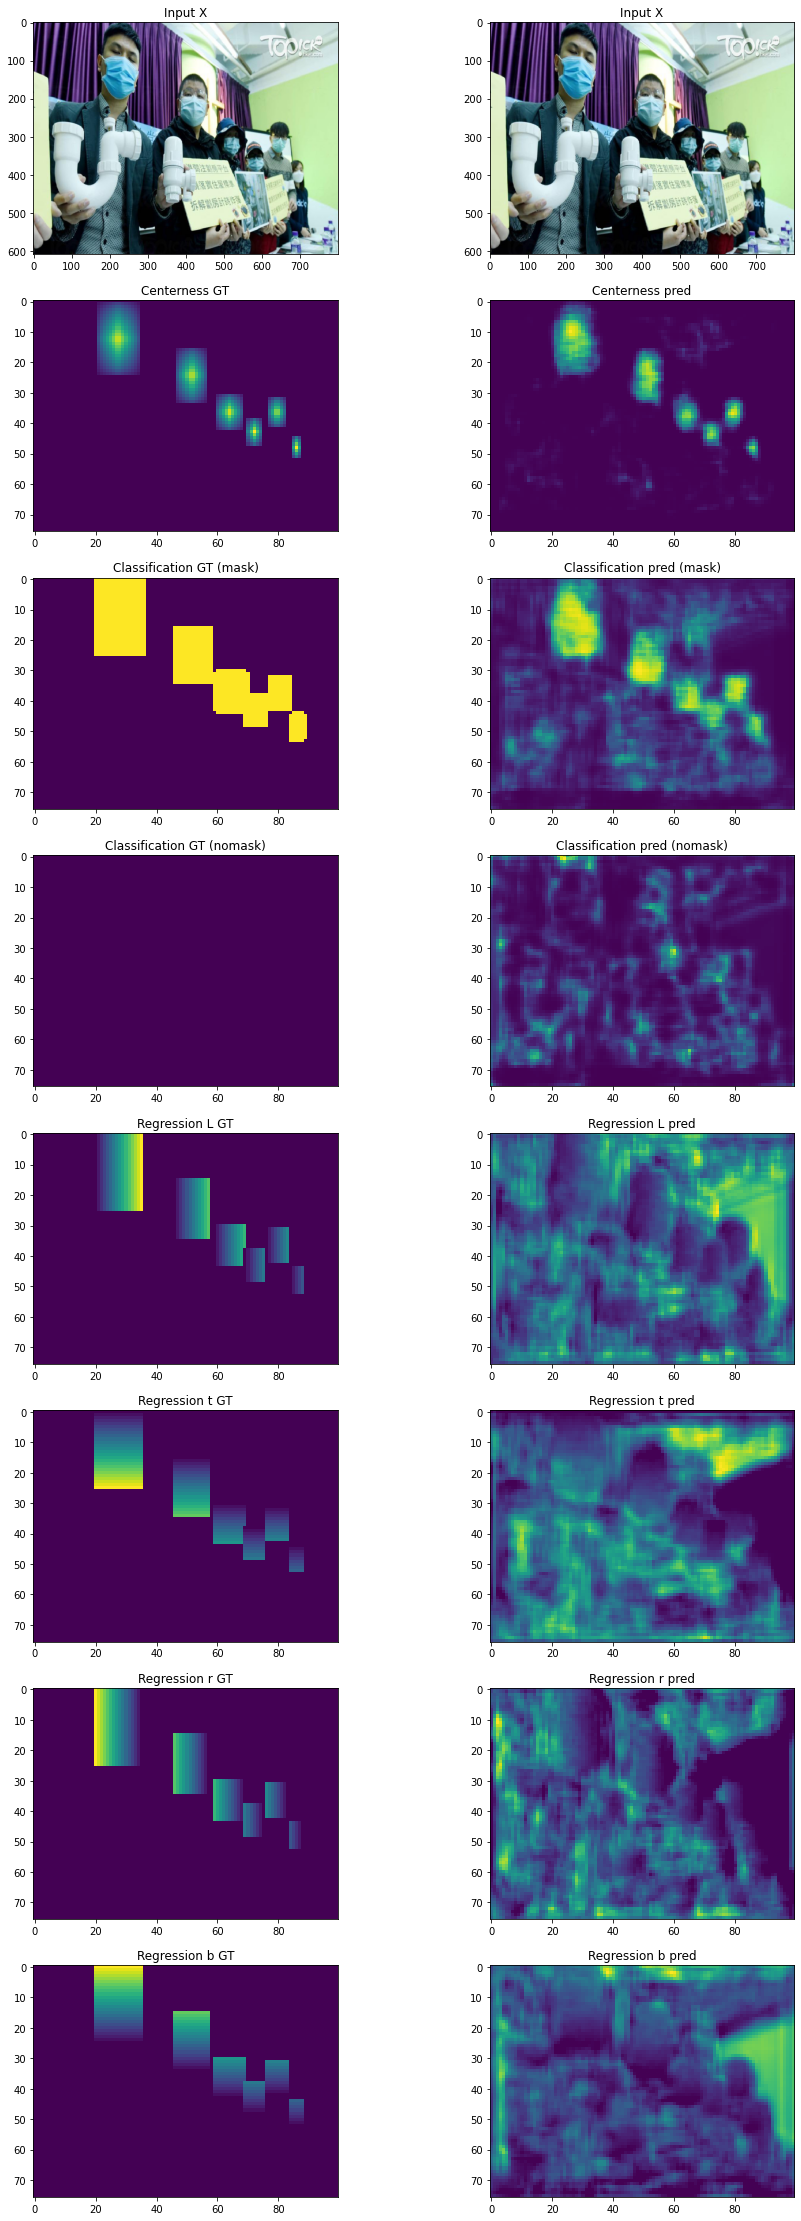

In [43]:
visualize_outputpredictions("train", 5)


### Observations:

From the loss graph:
- The model loss stops decreasing after 40 iterations. 

From visualizing the model outputs:
- the model **predicts fairly well** the centerness targets
- the classification branch performs a lot better on the mask class, compared to the no-mask class (which was expected)
- The model **doesn't seem to learn** the mapping between the input and the regression targets (for the training set as well). 

Despite our initial observation, we will see in the next section that the regression branch did learn a useful representation.

## Post Processing 

This final section focuses on displaying the predictions on the original image.

Steps :
1. From the CNN output (classification & centerness), we select all Region of Interests (ROI) over a certain threshold.
2. We calculate the center for each ROI and get the bounding box dimensions from the CNN output (regression)
3. We apply the NMS algorithm to remove overlapping bounding boxes.
4. We print all the predicted and expected bounding boxes on the original image.

In [44]:
def get_predicted_bbox_coordinates(folder, num_image, threshold=0.25):
    """
    Bbox list = [(class, confidence score, Xmin, Ymin, Xmax, Ymax), ...]
    """
    # Prediction for a single image
    if folder == "train":
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_train[num_image], 0)
        )
    elif folder == "valid":
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_valid[num_image], 0)
        )
    else:
        output_center, output_classi, output_regre = model.predict(
            np.expand_dims(x_test[num_image], 0)
        )

    # Multiply the centerness with the classification output
    pred_mask = (output_center[0, ..., 0] * output_classi[0, ..., 0]) > threshold
    pred_nomask = (output_center[0, ..., 0] * output_classi[0, ..., 1]) > threshold

    # Detecting how many masks and nomasks are detected
    contours_mask = cv2.findContours(
        pred_mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )[0]
    contours_nomask = cv2.findContours(
        pred_nomask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )[0]

    # For the conversion to the CNN input dimension
    ratio_width = (
        WIDTH / output_center.shape[2]
    )  # ratio = Width of CNN input / Width of CNN output
    ratio_height = (
        HEIGHT / output_center.shape[1]
    )  # ratio = Height of CNN input / Height of CNN output

    bbox_list_mask = []
    bbox_list_nomask = []
    class_name = "mask"

    for contours in [contours_mask, contours_nomask]:
        for c in contours:
            # OpenCV: (X,Y) = top left corner of the rectangle
            # (X on the width axis, Y on the height axis)
            x, y, w, h = cv2.boundingRect(c)

            # Axis between OpenCV and Numpy arrays are reversed
            l, t, r, b = output_regre[
                0, y + int(h / 2), x + int(w / 2), :
            ]  # Center of bounding box

            # Left and right side distances (between 0-1) converted to CNN output channel (between 0-100)
            l = int(l * output_center.shape[2])
            r = int(r * output_center.shape[2])
            # Top and bottom side distances (between 0-1) converted to CNN output channel (between 0-76)
            t = int(t * output_center.shape[1])
            b = int(b * output_center.shape[1])

            ## Top left Corner of the rectangle converted in the CNN input dimensions
            # For center of bounding box
            topleft_horizontal = int((x + int(w / 2)) * ratio_width) - int(
                l * ratio_width
            )
            topleft_vertical = int((y + int(h / 2)) * ratio_height) - int(
                t * ratio_height
            )
            bbox_width = topleft_horizontal + int((l + r) * ratio_width)
            bbox_height = topleft_vertical + int((t + b) * ratio_height)

            # If topleft is out of the frame, set to 0
            if topleft_horizontal < 0:
                topleft_horizontal = 0
            if topleft_vertical < 0:
                topleft_vertical = 0

            # if width or height is > to framework dimension
            if bbox_width > WIDTH:
                bbox_width = WIDTH - topleft_horizontal
            if bbox_height > HEIGHT:
                bbox_height = HEIGHT - topleft_vertical

            if class_name == "mask":
                confidence = (
                    output_center[0, y + int(h / 2), x + int(w / 2), 0]
                    * output_classi[0, y + int(h / 2), x + int(w / 2), 0]
                )
                # (class, confidence score, Xmin, Ymin, Xmax, Ymax)
                bbox_list_mask += [
                    (
                        "mask",
                        confidence,
                        topleft_vertical,
                        topleft_horizontal,
                        bbox_height,
                        bbox_width,
                    )
                ]
            else:
                confidence = (
                    output_center[0, y + int(h / 2), x + int(w / 2), 0]
                    * output_classi[0, y + int(h / 2), x + int(w / 2), 1]
                )
                bbox_list_nomask += [
                    (
                        "nomask",
                        confidence,
                        topleft_vertical,
                        topleft_horizontal,
                        bbox_height,
                        bbox_width,
                    )
                ]

        class_name = "nomask"

    return bbox_list_mask, bbox_list_nomask


We apply the **Non Maximum Suppression (NMS) algorithm** to remove the overlapping bounding boxes in order to improve the accuracy. We feed the NMS algorithm two lists (mask and nomask list) instead of a single unified list because we want to remove the overlapping bounding boxes of the same class. It's far more likely that overlapping bounding boxes from the same classes are false positives. If two different classes are overlapping, it's possible one object is in front of the other.

In [45]:
def non_max_suppression(boundingbox_list, iou=0.4):
    label = []
    confidence_score = []
    bbox_coordinates = []

    if len(boundingbox_list) != 0:
        for i, bbox in enumerate(boundingbox_list):
            label += [bbox[0]]
            confidence_score += [bbox[1]]
            bbox_coordinates.append(
                [bbox[3], bbox[2], bbox[5], bbox[4]]
            )  # Ymin, Xmin, Ymax, Xmax

        # Highest number of objects in a single image in our dataset
        max_boxes_tensor = tf.Variable(100, dtype="int32")
        # NMS algorithm
        selected_indices = tf.image.non_max_suppression(
            bbox_coordinates, confidence_score, max_boxes_tensor, iou_threshold=iou
        )
        selected_boxes = tf.gather(bbox_coordinates, selected_indices)
        selected_confidence = tf.gather(confidence_score, selected_indices)

        return selected_confidence, selected_boxes


We would like to visualize on the original image (before the CNN input resizing) a list of predicted boxes with the true labels.

In [58]:
def display_predictedANDtrueboxes(folder, num_image, bbox_list, save=False):
    # filename_images is 1-indexed compared to the training data (0 indexed)
    # Getting the correct filepath
    path_im = {
        "train": dataset_path / "train" / train_filename_images[num_image + 1],
        "valid": dataset_path / "valid" / valid_filename_images[num_image + 1],
        "test": dataset_path / "test" / test_filename_images[num_image + 1],
    }

    path_label = {
        "train": dataset_path / "train" / train_filename_labels[num_image + 1],
        "valid": dataset_path / "valid" / valid_filename_labels[num_image + 1],
        "test": dataset_path / "test" / test_filename_labels[num_image + 1],
    }

    # Extract boxes coordinates
    boxes_mask, boxes_nomask, w, h = extract_boxes(path_label[folder])

    img = cv2.imread(str(path_im[folder]))

    # Drawing the true labels
    for Xmin, Ymin, Xmax, Ymax in boxes_mask:
        cv2.rectangle(img, (Xmin, Ymin), (Xmax, Ymax), (0, 255, 0), 1)  # Green

    for Xmin, Ymin, Xmax, Ymax in boxes_nomask:
        cv2.rectangle(img, (Xmin, Ymin), (Xmax, Ymax), (0, 0, 255), 1)  # Red

    # Drawing the predicted labels
    for bbox in bbox_list:
        label, confidence, Xmin, Ymin, Xmax, Ymax = (
            bbox[0],
            bbox[1],
            bbox[2],
            bbox[3],
            bbox[4],
            bbox[5],
        )
        if label == "mask":
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)

        # Converting to original image size
        ratio_h = h / HEIGHT
        ratio_w = w / WIDTH
        Xmin = int(Xmin * ratio_w)
        Xmax = int(Xmax * ratio_w)
        Ymin = int(Ymin * ratio_h)
        Ymax = int(Ymax * ratio_h)

        # Predicted Bounding box
        cv2.rectangle(img, (Xmin, Ymin), (Xmax, Ymax), color, 4)

        ## Adding class and confidence above predicted bounding box
        # Finds space required by the text so that we can put a background with that amount of width.
        label = label + " " + str(int(confidence * 100)) + "%"
        # Space required for the text (serves a)
        (w_space, h_space), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        # Adding a background to the text
        img = cv2.rectangle(img, (Xmin, Ymin + 20), (Xmin + w_space, Ymin), color, -1)
        # Printing the text
        img = cv2.putText(
            img, label, (Xmin, Ymin + 17), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1
        )

    if not save:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)


We combine all the elements:

In [59]:
def post_processing_mask(
    folder, num_image, save=False, thresholdROI=0.35, thresholdIOU=0.5
):
    # Steps 1 & 2 : ROI selection + Box dimension
    bbox_mask, bbox_nomask = get_predicted_bbox_coordinates(
        folder, num_image, threshold=thresholdROI
    )

    # Step 3 : NMS
    boundingbox = []  # [(class, confidence score, Xmin, Ymin, Xmax, Ymax), ...]
    class_name = "mask"

    for bbox_list in [bbox_mask, bbox_nomask]:
        if len(bbox_list) != 0:
            confidence_score, bbox = non_max_suppression(bbox_list, iou=thresholdIOU)
            for i in range(len(confidence_score)):
                boundingbox.append(
                    [
                        class_name,
                        confidence_score[i].numpy(),
                        bbox[i][0].numpy(),
                        bbox[i][1].numpy(),
                        bbox[i][2].numpy(),
                        bbox[i][3].numpy(),
                    ]
                )
        class_name = "nomask"

    # Step 4 : Visualisation
    display_predictedANDtrueboxes(folder, num_image, boundingbox)


We show a few examples The thin green bounding box is the ground truth and the bold green is the prediction.

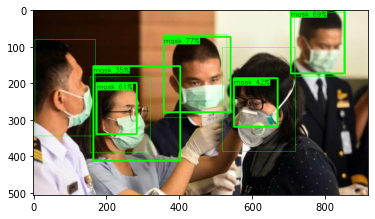

In [60]:
post_processing_mask("test", 2)


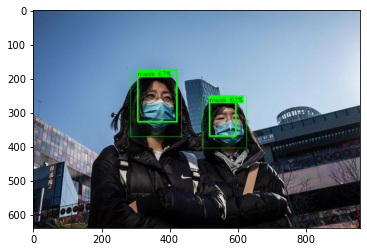

In [61]:
post_processing_mask("test", 3)


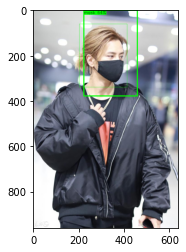

In [62]:
post_processing_mask("test", 4)
